In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import numpy as np
from itertools import product
import warnings

# Dataset
Dataset: Monthly gold cost from 1950 to 2020 ([kaggle](https://www.kaggle.com/datasets/tunguz/gold-prices?select=monthly_csv.csv))

In [96]:
# Data
df = pd.read_csv('monthly_csv.csv', parse_dates=['Date'], encoding='cp1251')
df['date'] = df['Date']
df['value'] = df['Price']
df = df.set_index(['date'])
df = df[['value']]
df = df.astype('float32')
df

,value
date,
1950-01-01,34.730000
1950-02-01,34.730000
1950-03-01,34.730000
1950-04-01,34.730000
1950-05-01,34.730000
...,...
2020-03-01,1593.764038
2020-04-01,1680.030029
2020-05-01,1715.697021


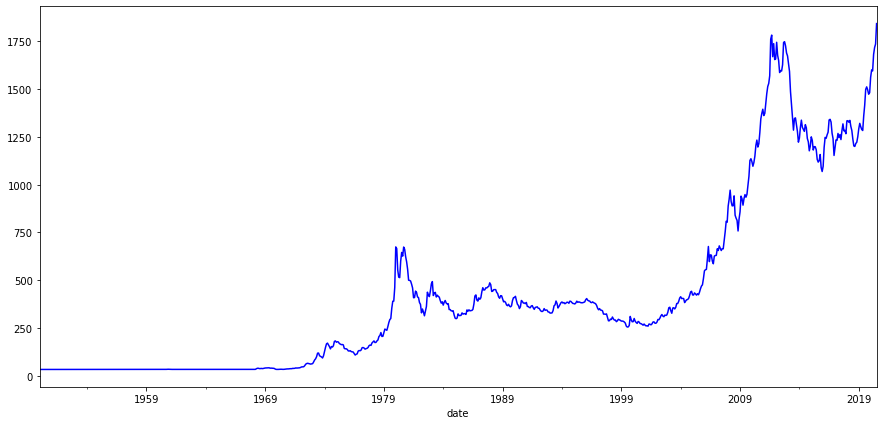

In [97]:
plt.figure(figsize=(15,7))
df['value'].plot(color='b')
plt.show()

In [ ]:
df_train = df.loc['2000-01-01':'2009-12-31'].copy()
df_test = df.loc['2010-01-01':'2011-12-31'].copy()

In [ ]:
df_train.shape[0] / 12, df_test.shape[0] / 12

In [ ]:
plt.figure(figsize=(15,7))
df_train['value'].plot(color='b')
df_test['value'].plot(color='r')
plt.show()

## Data autocorrelation
As expected, the most correlated data are:
- day with several previous days (~1)
- day with day a year ago (~365)

while data for opposite seasons (~180) is anticorrelated

In [ ]:
fig = sm.graphics.tsa.plot_acf(df_train['value'], lags=100)
fig.set_size_inches((15, 6))
fig.tight_layout()
plt.show()

fig = sm.graphics.tsa.plot_pacf(df_train['value'], lags=20)
fig.set_size_inches((15, 6))
fig.tight_layout()
plt.show()

## Components evaluation on of time-series

In [ ]:
fig = sm.tsa.seasonal_decompose(df_train['value'], period=12).plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

### Dickey-Fuller test for time-series stationarity.
As expected, the data is non-stationary p>0.05 (as all data with seasons)

In [ ]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train['value'])[1])

## Box-Cox transformation for dispersion stationarity
To apply Box-Cox transformation I add minimum `TMAX` value to all `TMAX` as it can be negative.\
Box-Cox transformation make dispersion lower but do not help much with this case as we do not have visible 

In [ ]:
MIN_VALUE = df_train['value'].min()
print("Min value to substract: %f" % MIN_VALUE)
df_train['value_box'], lmbda = stats.boxcox(df_train['value'] + 0 if MIN_VALUE > 0 else np.abs(MIN_VALUE) + 1e-6)
print("Best Box-Cox parameter: %f" % lmbda)

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_train['value_box'], c='blue')
plt.ylabel('Transformed by Box-Cox data')
plt.show()

In [ ]:
fig = sm.tsa.seasonal_decompose(df_train['value_box'], period=12).plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

In [ ]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train['value_box'])[1])

## Derivative transformation for seasoning stationarity
Method of derivative helps to make seasoning data stationar by substruction data before lag from current.

In [ ]:
df_train['value_box_diff1'] = df_train['value_box'].diff()

In [ ]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train['value_box_diff1'][1:], autolag='AIC')[1])

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df_train['value_box_diff1'], c='blue')
plt.ylabel('Transformed by derivative data')
plt.show()

In [ ]:
fig = sm.tsa.seasonal_decompose(df_train['value_box_diff1'][1:]).plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

In [ ]:
df_train['value_box_diff1s'] = df_train['value_box'] - df_train['value_box'].shift(12)
df_train['value_box_diff2s'] = df_train['value_box_diff1s'] - df_train['value_box_diff1s'].shift(12)

In [ ]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train['value_box_diff1s'][12:], autolag='AIC')[1])

In [ ]:
fig = sm.tsa.seasonal_decompose(df_train['value_box_diff1s'][12:]).plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

## SARIMA model

parameters for SARIMA model\
better use values < 10\
p and P - show how many autoregressive (AR) terms for non-seasonal (p) and Seasonal (P) component do we want to use\
q and Q - show how many moving average (MA) terms for non-seasonal (q) and Seasonal (Q) component do we want to use\
d - show how many times have we derivated our series 1-step-wise\
D - show how many times have we derivated our series Period-step-wise

In [ ]:
fig = sm.graphics.tsa.plot_acf(df_train['value_box'], lags=30)
fig.set_size_inches((15, 6))
fig.tight_layout()
plt.show()

fig = sm.graphics.tsa.plot_pacf(df_train['value_box'], lags=30)
fig.set_size_inches((15, 6))
fig.tight_layout()
plt.show()

In [ ]:
qs = [9, 10, 11]
Qs = [0, 1]
ps = [1]
Ps = [0]
d = 1
D = 1

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

In [ ]:
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(df_train['value_box'], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())     

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

In [ ]:
print(best_model.summary())

In [ ]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda) + (MIN_VALUE + 1e6 if MIN_VALUE < 0 else 0)

In [ ]:
df_train['value_model'] = invboxcox(best_model.fittedvalues, lmbda)
df_test['value_forecast'] = invboxcox(best_model.predict(start=12 * 10, end=12 * 13), lmbda)

In [ ]:
plt.figure(figsize=(15,7))
df_train['value'].plot(color='b')
# df_train['value_model'][12:].plot(color='r')
df_test['value'].plot(color='b')
df_test['value_forecast'].plot(color='r')
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

print('R2 = %f' % r2_score(df_test['value'], df_test['value_forecast']))
print('MSE = %f' % mean_squared_error(df_test['value'], df_test['value_forecast']))
print('MAPE = %f' % mean_absolute_percentage_error(df_test['value'], df_test['value_forecast']))

## LSTM

RNN - LSTM for time-series forecasting
partly follows blog https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array
 
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input series (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # prediction series (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

 
# train / test splitting
def prepare_data(series, n_batch, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test-n_seq+1], supervised_values[-n_test:]
    
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    print(X.shape, y.shape)
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    # stateful = True - keep state in memory;
    model.add(LSTM(n_neurons, input_shape=(X.shape[1], X.shape[2]), dropout=0.5))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error')
    model.fit(X, y, validation_split=0.2,epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=True)
    
    return model
 
# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    
    return [x for x in forecast[0, :]]
 
# Forecasting
def make_forecasts(model, n_batch, train, test, n_test, n_lag, n_seq):
    forecasts = list()
    for i in range(n_test):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
        
    return forecasts
 
# inverse difference
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
        
    return inverted
 
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test, n_lag, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        print(len(series), n_test, n_seq, len(series) - n_test - n_seq + i)
        index = len(series) - n_test - n_seq + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
        
    return inverted

Hyperparameters initialization and training the model

In [ ]:
n_lag = 12
n_seq = 24
n_test = 1
n_epochs = 50
n_batch = 1
n_neurons = 10

In [ ]:
df = df.loc['2000-01-01':'2011-12-31']

In [ ]:
scaler, train, test = prepare_data(df, n_batch, n_test, n_lag, n_seq)

model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_test, n_lag, n_seq)

forecasts = inverse_transform(df, forecasts, scaler, n_test, n_lag, n_seq)

In [ ]:
# visualize

plt.figure(figsize = (15,6))
plt.plot(df, c='blue')

xaxis = df.index.values[-len(forecasts[0]):]
yaxis = forecasts[0]
plt.plot(xaxis, yaxis, color='r')

plt.ylabel('Max day temperature in Sydney')
plt.xlabel('Days since January 2012 to January 2017')

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()


In [ ]:
df_test['value_forecast'] = forecasts[0]

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

print('R2 = %f' % r2_score(df_test['value'], df_test['value_forecast']))
print('MSE = %f' % mean_squared_error(df_test['value'], df_test['value_forecast']))
print('MAPE = %f' % mean_absolute_percentage_error(df_test['value'], df_test['value_forecast']))